# Latest available activity for data sources in OpenSAFELY

This notebook provides information about build times and recent activity in the OpenSAFELY-TPP database. 

A "build" is the process that transforms the source data (including both primary care information in SystmOne, and externally linked datasets from SUS, ONS etc) into the OpenSAFELY database that can be queried in the secure environment. 
Database builds occur approximately weekly. 
External datasets are only re-built if new data has been received (or "ingested") by TPP.

Event activity (i.e., counts of patient events such as hospital admissions and deaths) is reported for each external dataset from 1 February up to the notebook run date, and for the latest 30 days of activity. 

The OpenSAFELY-TPP database only includes patients recently (< 5 years) or actively registered at a GP practice using TPP's SystmOne clinical information system (roughly 40% of English residents). 
Event activity therefore reflects these patients only, including information from external data sources. 

This notebook can be used to:

* Obtain the most recent build date for each data source
* Obtain the frequency of historical build dates for each external data source
* Obtain the most recent event date for each data source amongst TPP patients
* Understand event activity amongst TPP patients from 1 February 2020 onwards
* Estimate the latest reliable date for events recorded in each data source, i.e., a cut-off beyond which the data may be incomplete.

This notebook can not be used to:

* Obtain the next database build time
* Understand patient activity over time at a national level
* Estimate the earliest reliable date for events recorded in each data source

### Data sources
Data sources are listed below, with the table name in the database given in brackets:

* Positive or negative SARS-CoV2 test, from SGSS (`SGSS_Positive` and `SGSS_Negative`)
* Positive SARS-CoV2 test, from SGSS (`SGSS_Positive`)
* A&E attendance, from SUS Emergency Care Data (`EC`)
* Hospital admission, from SUS Admitted Patient Care Data (`APCS`)
* Covid-related ICU admission, from ICNARC (`ICNARC`)
* Covid-related in-hospital death, from CPNS (`CPNS`)
* All-cause registered deaths, from ONS (`ONS_Deaths`)

For primary care data in SystmOne (`S1`), the delay from events occurring in reality to being available in OpenSAFELY is 2 - 9 days.
Reducing this to one day is possible for urgent queries where necessary.

Note that SGSS only provides the first known positive test for any person (with a few unexplained exceptions), so there won't be multiple positive tests per patient in SGSS data.
Negative tests in SGSS are unreliable. 

Additional data sources include:
* High cost drugs (`HighCostDrugs`)
* Unique Property Reference Number, used for deriving household variables (`UPRN`)
* Master Patient Index (`MPI`)

In [1]:
## Import libraries

%load_ext autoreload
%autoreload 2

import pyodbc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.dates as mdates
from contextlib import contextmanager
from datetime import date, datetime
from IPython.display import display, Markdown

import sys
sys.path.append('../lib/')
from functions import *

# get server credentials from environ.txt
dbconn = os.environ.get('DBCONN', None).strip('"')

In [2]:
## Import libraries

with closing_connection(dbconn) as cnxn:
    DBbuild = pd.read_sql("""select * from LatestBuildTime""", cnxn)
    tablebuilds = DBbuildtimes(cnxn, up_to=None)
    allbuilds = pd.read_sql("""select * from BuildInfo""", cnxn)

# select start and end dates
start_date = pd.to_datetime("2020-02-01", format='%Y-%m-%d')
#start_date = pd.to_datetime("2020-02-01", format='%Y-%m-%d')
end_date = pd.to_datetime(DBbuild['DtLatestBuild'].values[0], format='%Y-%m-%d')
today = date.today()

### Notebook run date

In [3]:
display(Markdown(f"""This notebook was run on {today.strftime('%Y-%m-%d')}.  The information below reflects the state of the OpenSAFELY-TPP as at this date."""))

This notebook was run on 2020-12-22.  The information below reflects the state of the OpenSAFELY-TPP as at this date.

### Latest OpenSAFELY-TPP database build

In [4]:
display(Markdown(f"""The most recent OpenSAFELY-TPP database build was {end_date.strftime('%Y-%m-%d')}."""))

The most recent OpenSAFELY-TPP database build was 2020-12-20.

## Latest dataset builds
The dates in the table below reflect when the datasets were last _built_ by TPP for the OpenSAFELY database. 
They do not reflect when the data were last _ingested_ by TPP.

In [5]:
tablebuilds

,dataset,latest_build
0,APCS,2020-12-09 13:14:15.483
1,CPNS,2020-12-14 10:34:01.620
2,EC,2020-12-14 10:58:51.940
3,ECDS,2020-04-21 14:48:09.543
4,HighCostDrugs,2020-11-27 14:15:31.460
5,ICNARC,2020-08-17 10:55:44.580
6,MPI,2020-08-05 11:26:13.247
7,ONS_Deaths,2020-12-18 09:46:58.680
8,OPA,2020-12-14 10:32:58.410
9,S1,2020-12-18 11:00:01.647


The figure below shows the dates of dataset builds for SystmOne (`S1`) data and for all external datasets, up until the latest build date (the vertical black line).

Text(0.5, 1.0, 'Latest dataset builds as at 2020-12-22')

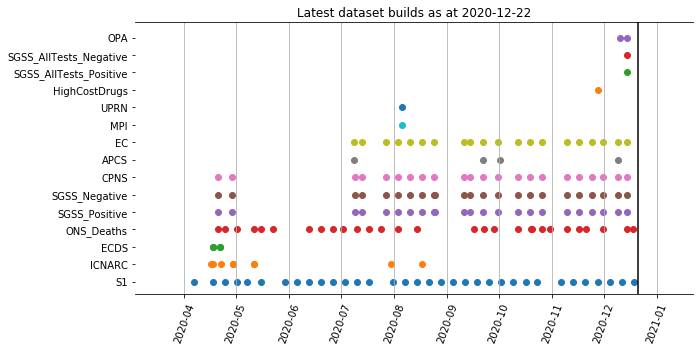

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

sources = allbuilds['BuildDesc'].unique()

for source in allbuilds['BuildDesc'].unique():
    dat = allbuilds[(allbuilds['BuildDesc']==source) & (allbuilds['BuildDate']<end_date)]
    x = dat['BuildDate']
    y = dat['BuildDesc']
    ax.scatter(x, y, marker='o')

ax.xaxis.set_tick_params(labelrotation=70)
ax.grid(True, axis='x')
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.axvline(end_date, color='black')
ax.set_title(f"""Latest dataset builds as at {today.strftime('%Y-%m-%d')}""")

## Event activity in external datasets
Event activity data is extracted directly from the OpenSAFELY-TPP database. 
All recorded events are extracted.

In [7]:
# Make a dataframe with consecutive dates
date_range = pd.DataFrame(
    index = pd.date_range(start=start_date, end=end_date, freq="D")
)

In [8]:
def datequery(table, var_table, var_df, from_date):
    query = (
      "select " + var_table + " as " + var_df
    + " from " + table
    + " where " + var_table + " >= convert(date, '" + from_date + "')"
    )
    return query

start_date_text = start_date.strftime('%Y-%m-%d')
#CodedEvent_query = datequery("CodedEvent", "ConsultationDate", "consultation_date", start_date_text)
#Appointment_query = datequery("Appointment", "SeenDate", "appointment_date", start_date_text)
APCS_query = datequery("APCS", "Admission_Date", "hosp_admission_date", start_date_text)
CPNS_query = datequery("CPNS", "DateOfDeath", "cpns_death_date", start_date_text)
EC_query = datequery("EC", "Arrival_Date", "ed_attendance_date", start_date_text)
ICNARC_query = datequery("ICNARC", "CONVERT(date, IcuAdmissionDateTime)", "icu_admission_date", start_date_text)
ONS_query = datequery("ONS_Deaths", "dod", "ons_death_date", start_date_text)
SGSS_query = datequery("""( 
         SELECT * FROM SGSS_Positive 
         UNION
         SELECT * FROM SGSS_Negative
         )  as a""", 
        "Earliest_Specimen_Date", "test_specimen_date", start_date_text)
SGSSpos_query = datequery("SGSS_Positive", "Earliest_Specimen_Date", "test_specimen_date", start_date_text)

with closing_connection(dbconn) as cnxn:
    #CodedEvent_df = pd.read_sql(CodedEvent_query, cnxn, parse_dates=['coded_event_date'])
    #Appointment_df = pd.read_sql(Appointment_query, cnxn, parse_dates=['appointment_date'])
    APCS_df = pd.read_sql(APCS_query, cnxn, parse_dates=['hosp_admission_date'])
    CPNS_df = pd.read_sql(CPNS_query, cnxn, parse_dates=['cpns_death_date'])
    EC_df = pd.read_sql(EC_query, cnxn, parse_dates=['ed_attendance_date'])
    ICNARC_df = pd.read_sql(ICNARC_query, cnxn, parse_dates=['icu_admission_date'])
    ONS_df = pd.read_sql(ONS_query, cnxn, parse_dates=['ons_death_date'])
    SGSS_df = pd.read_sql(SGSS_query, cnxn, parse_dates=['test_specimen_date'])
    SGSSpos_df = pd.read_sql(SGSSpos_query, cnxn, parse_dates=['test_specimen_date'])
    
# Note that CodedEvent and Appointment extracts take a long time to run.


The plots below show activity for 1 Feb 2020 onwards (left plot) and for the last 30 days up to the most recent event date (right plot). 
Counts less than five are redacted. 



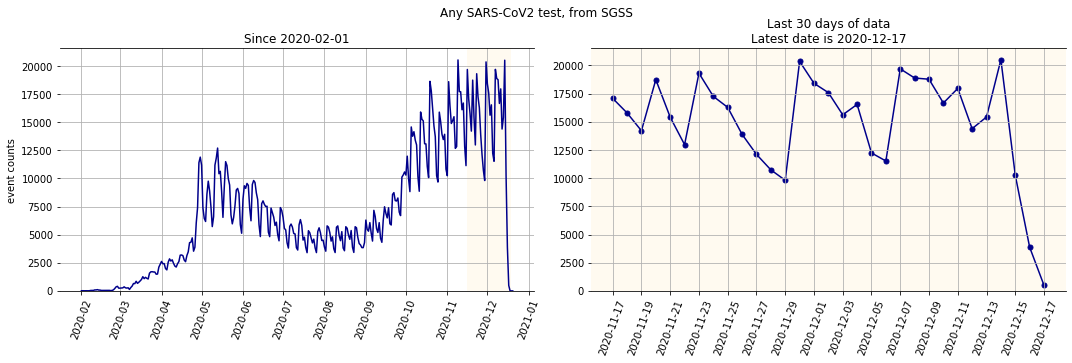

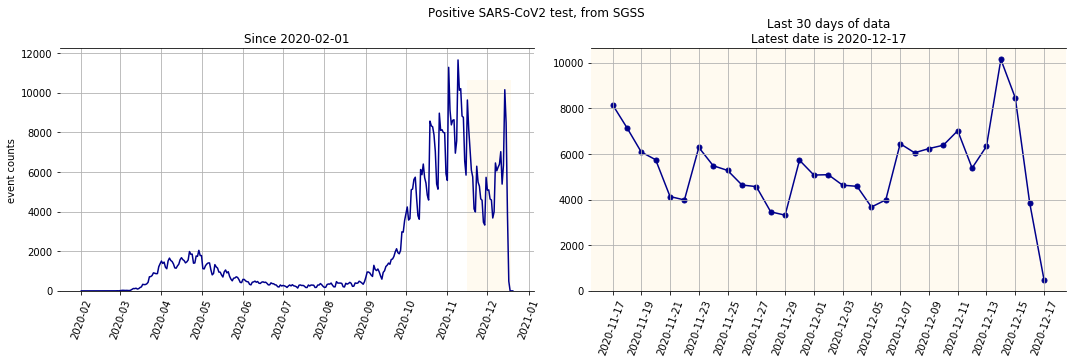

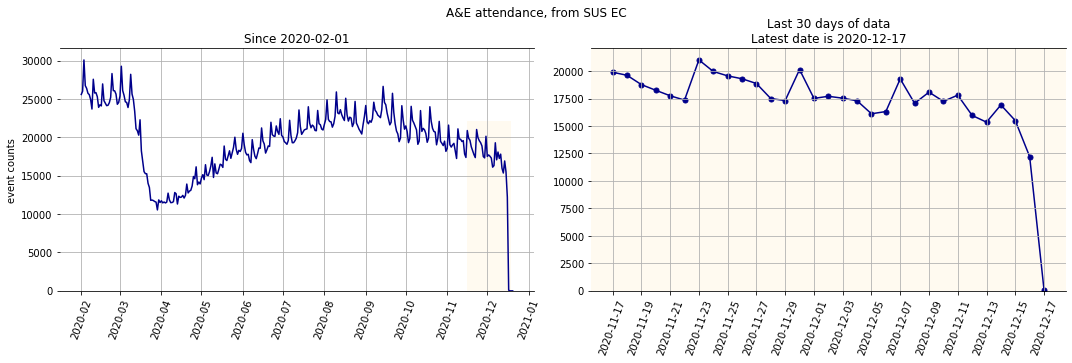

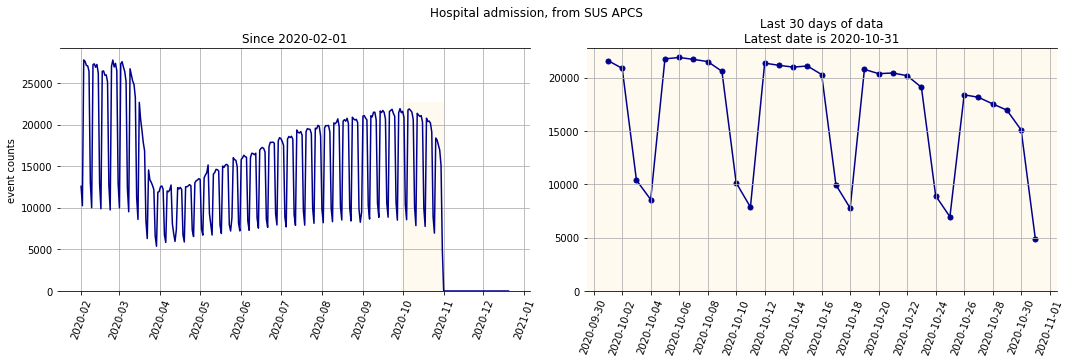

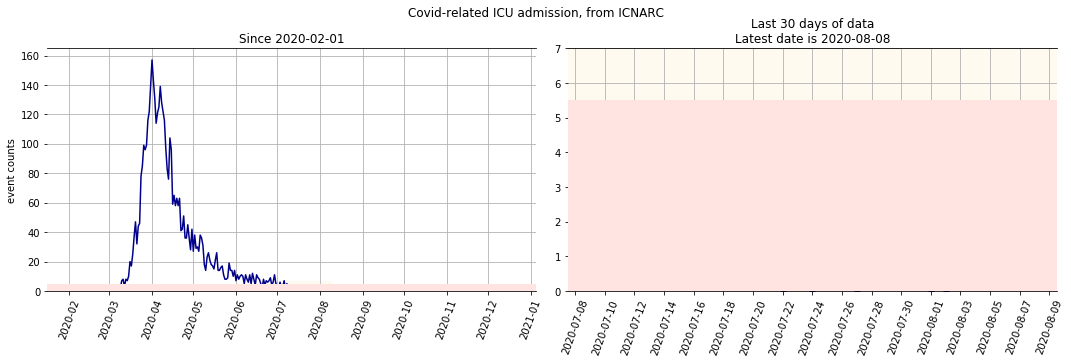

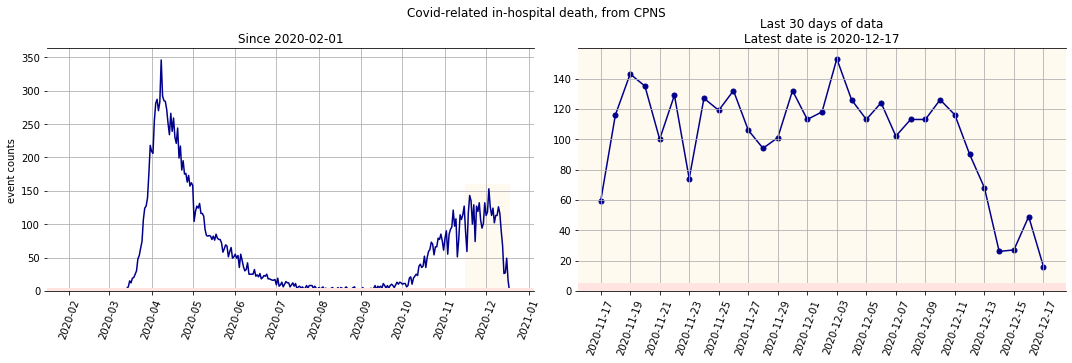

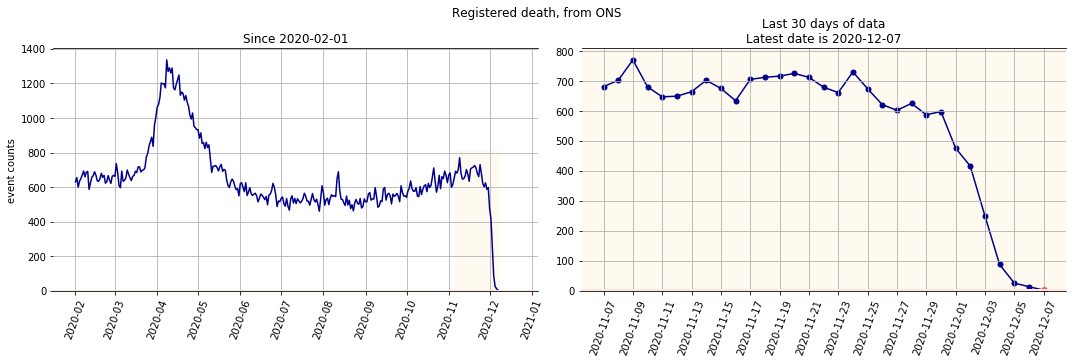

In [9]:
#plotcounts(date_range, CodedEvent_df['coded_event_date'], title="Any coded event in Primary Care, from SystmOne")
plotcounts(date_range, SGSS_df['test_specimen_date'], title="Any SARS-CoV2 test, from SGSS")
plotcounts(date_range, SGSSpos_df['test_specimen_date'], title="Positive SARS-CoV2 test, from SGSS")
plotcounts(date_range, EC_df['ed_attendance_date'], title="A&E attendance, from SUS EC")
plotcounts(date_range, APCS_df['hosp_admission_date'], title="Hospital admission, from SUS APCS")
plotcounts(date_range, ICNARC_df['icu_admission_date'], title="Covid-related ICU admission, from ICNARC")
plotcounts(date_range, CPNS_df['cpns_death_date'], title="Covid-related in-hospital death, from CPNS")
plotcounts(date_range, ONS_df['ons_death_date'], title="Registered death, from ONS")

In [10]:
### number of visits per patient

def recurrentquery(table, id_table, date_table, from_date, head=5):
    query = (
    f"""
    SELECT a.*, b.patients_with_exactly_X_events 
    FROM (
        SELECT X, COUNT(X) AS patients_with_at_least_X_events 
        FROM
        (
            SELECT {id_table}, ROW_NUMBER() OVER(PARTITION BY {id_table} ORDER BY {id_table})  AS X
            FROM {table}
            WHERE {date_table} >= CONVERT(date, '{from_date}')
        ) AS a
        GROUP BY X
    ) AS a
    LEFT JOIN
    (
        SELECT X, COUNT(X) AS patients_with_exactly_X_events 
        FROM
        (
            select count(*) AS X
            FROM {table}
            WHERE {date_table} >= CONVERT(date, '{from_date}')
            GROUP BY {id_table}
        ) AS a
        GROUP BY X
    ) AS b
    ON a.X=b.X
    ORDER BY a.X
    """
    )
    
    display(Markdown(f"### Repeat events in {table}"))
    display(pd.read_sql(f"select count(*) as total_events from {table} where {date_table} >= CONVERT(date, '{from_date}')", cnxn))
    display(pd.read_sql(query, cnxn).fillna(0).astype(int).head(head).set_index("X"))
    print(" ")

## Recurrent events / repeat patient IDs
Some datasets may have multiple rows per patient, for instance if the patient was admitted to hospital more than once. 
Currently a study definition can return either the first event, the last event, or the count of events occurring during the period of interest. 
The tables below count recurrent events for each dataset from 1 February onwards, up to 5 events. 

`patients_with_at_least_1_events` is the number of unique patients in the dataset. 
This is the number of events that can be returned by a study variable that takes the first event or the last event, from 1 February onwards. 

In [11]:
with closing_connection(dbconn) as cnxn:
    recurrentquery("APCS", "Patient_ID", "Admission_Date", start_date_text, 5)
    recurrentquery("CPNS", "Patient_ID", "DateOfDeath", start_date_text, 5)
    recurrentquery("EC", "Patient_ID", "Arrival_Date", start_date_text, 5)
    recurrentquery("ICNARC", "Patient_ID", "IcuAdmissionDateTime", start_date_text, 5)
    #recurrentquery("SGSS", "Patient_ID", "Earliest_Specimen_Date", start_date_text, 5)
    recurrentquery("SGSS_Positive", "Patient_ID", "Earliest_Specimen_Date", start_date_text, 5)
    recurrentquery("ONS_Deaths", "Patient_ID", "dod", start_date_text, 5)

### Repeat events in APCS

,total_events
0,4371186


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,2407611,1651827
2,755784,423971
3,331813,145537
4,186276,65499
5,120777,36802


### Repeat events in CPNS

,total_events
0,18315


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,18315,18315


### Repeat events in EC

,total_events
0,6319871


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,4089798,2881830
2,1207968,758530
3,449438,246134
4,203304,96913
5,106391,43941


### Repeat events in ICNARC

,total_events
0,4561


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,3740,3109
2,631,488
3,143,108
4,35,25
5,10,8


### Repeat events in SGSS_Positive

,total_events
0,651030


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,650799,650568
2,231,231


### Repeat events in ONS_Deaths

,total_events
0,204074


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,204073,204072
2,1,1


## Notes on OpenSAFELY

OpenSAFELY is a data analytics platform built by a mixed team of software developers, clinicians, and epidemiologists from the Oxford DataLab, London School of Hygiene and Tropical Medicine Electronic Health Record research group, health software company TPP and NHS England. It represents a fundamentally different way of conducting electronic health record (EHR) research: instead of sending EHR data to a third party for analysis, we've developed a system for conducting analyses within the secure environment where the data is already stored, so that the electronic health record data never leaves the NHS ecosystem. 

Currently, OpenSAFELY uses the electronic health records of all patients registered at a GP practice using the SystmOne clinical information system run by TPP, covering around 22 million people. Additional data for these patients covering COVID-related tests, hospital admissions, ITU admissions, and registered deaths are also securely imported to the platform. 

For more information, visit https://opensafely.org